`Install Dependencies`

In [2]:
# Install Hugging Face Transformers (for models & tokenizers)
# Install datasets (to load and handle datasets)
# Install evaluate & rouge_score (for metrics)
!pip install -q transformers datasets evaluate rouge_score accelerate sentencepiece sacremoses sumy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━

In [3]:
# import torch
# print("CUDA available:", torch.cuda.is_available())
# print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


In [4]:
from datasets import load_dataset
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import BartForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import evaluate

`Load CNN/DailyMail Dataset`

In [5]:
dataset = load_dataset("cnn_dailymail", "3.0.0")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [7]:
sample = dataset["validation"][0]
print("Article:\n", sample["article"][:500], "...")
print("\nHighlight (Summary):\n", sample["highlights"])


Article:
 (CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her ge ...

Highlight (Summary):
 Zully Broussard decided to give a kidney to a stranger .
A new computer program helped her donation spur transplants for six kidney patients .


`Try Baseline Abstractive Summarization`

In [8]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0)  # device=0 uses GPU
text = dataset["validation"][0]["article"]
print("INPUT length:", len(text.split()))
print(summarizer(text, max_length=130, min_length=30, do_sample=False)[0]["summary_text"])


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


INPUT length: 748
Zully Broussard gave one of her kidneys to a stranger. Her generosity paired up with big data. It resulted in six patients receiving transplants. The chain of surgeries is to be wrapped up Friday.


`EDA (Exploratory Data Analysis)`

In [9]:
# Shuffle the train dataset before sampling
dataset_shuffled = dataset["train"].shuffle(seed=36)

# Convert first 2000 random samples to DataFrame
df_train = pd.DataFrame(dataset_shuffled[:3000])

df_train.head()



,article,highlights,id
0,By . Daily Mail Reporter . PUBLISHED: . 17:43 ...,"Luerissie Ashley Ross, 20, charged with murder...",7e93e6d31282e3734e58195974e47cb41e4a8675
1,By . Laura Cox and Daily Mail Reporter . PUBLI...,NBA star was signed by the Knicks just three d...,131095d3b4b2a63096dae5866260546948259811
2,"(CNN) -- The world's best female golfer, Loren...",Lorena Ochoa and Tiger Woods first met at the ...,64ba7ac2c779383fd3e0ba0ca2b645ab1de67458
3,Washington (CNN) -- Protesting members of the ...,"Kansas group has 3 people at cemetery, saying ...",bb357ffed6cd816e3b2768f86147dd0a5289fabb
4,By . Daily Mail Reporter . Fisher-Price is fac...,Campaign for Commercial Free Childhood say Fis...,5da744fc907c5ba1f6c1dec2e3404ce285e684a8


In [10]:
# Calculate length of articles and summaries (in words)
df_train["article_len"] = df_train["article"].apply(lambda x: len(x.split()))
df_train["summary_len"] = df_train["highlights"].apply(lambda x: len(x.split()))

# Get basic stats
df_train[["article_len", "summary_len"]].describe()

,article_len,summary_len
count,3000.000000,3000.000000
mean,699.892333,51.772667
std,340.364048,19.883966
min,52.000000,9.000000
25%,449.750000,38.000000
50%,638.000000,49.000000
75%,883.500000,60.000000
max,1916.000000,167.000000


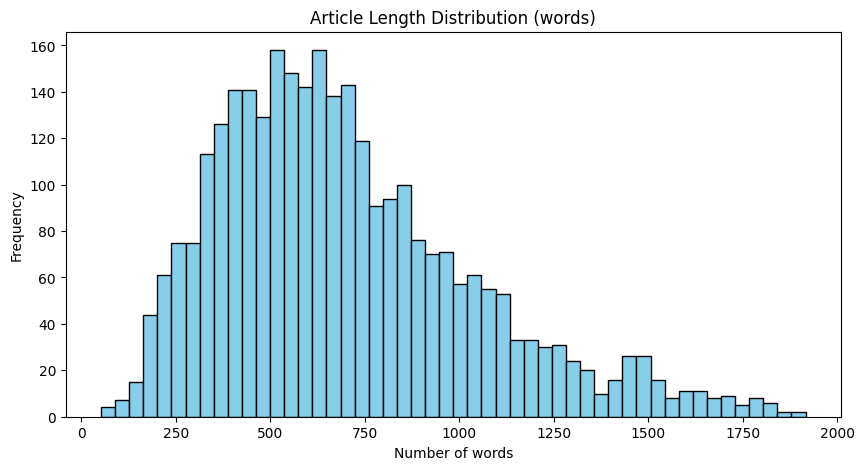

In [11]:

plt.figure(figsize=(10,5))
plt.hist(df_train["article_len"], bins=50, color='skyblue', edgecolor='black')
plt.title("Article Length Distribution (words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


`Preprocessing & Tokenization`

In [12]:
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)

longest_article = df_train.loc[df_train["article_len"].idxmax(), "article"]

tokens = tokenizer.encode(longest_article, truncation=False)
print("Number of tokens:", len(tokens))

Number of tokens: 2707


In [13]:
max_input_length = 1024
max_target_length = 128

def preprocess(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    )

    # Tokenize labels (summaries) and add padding
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["highlights"],
            max_length=max_target_length,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset["train"].column_names
)


Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


`Model Training`

In [ ]:

model = BartForConditionalGeneration.from_pretrained(model_name)


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_eval_batch_size=3,
    weight_decay=0.05,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    logging_dir='./logs',
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    save_strategy="epoch"
)


`Evaluate using ROUGE Score`

In [ ]:

rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )
    return {k: round(v * 100, 2) for k, v in result.items()}


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].select(range(500)),
    eval_dataset=tokenized_datasets["validation"].select(range(200)),
    processing_class=tokenizer, # Updated from tokenizer=tokenizer
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()


In [ ]:
results = trainer.evaluate()
print(results)


`Save the model`

In [ ]:
model.save_pretrained("./assets/model")
tokenizer.save_pretrained("./assets/tokenizer")


In [ ]:
from google.colab import files
import os

!zip -r assets2.zip ./assets2

files.download('assets.zip')

`Quick Inference Test`

In [ ]:
test_text = dataset["validation"][0]["article"]
test_text

In [ ]:
summarizer = pipeline("summarization", model="./assets", tokenizer="./assets", device=0)
print(summarizer(test_text, max_length=130, min_length=30, do_sample=False)[0]["summary_text"])